<a href="https://colab.research.google.com/github/spesivan/colab-notes-v2/blob/main/pytorch_unet_training_setup_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/spesivan/unet_pytorch.git

Cloning into 'unet_pytorch'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 3), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (23/23), 10.82 KiB | 10.82 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
!pip install getpass
!pip install roboflow --quiet
from getpass import getpass
from roboflow import Roboflow

ERROR: Could not find a version that satisfies the requirement getpass (from versions: none)
ERROR: No matching distribution found for getpass
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00


In [ ]:
api_key = getpass('Enter YOUR_API_KEY secret value: ')

# bYbWrPpLt1yNAM2mBTmX
# https://universe.roboflow.com/university-bswxt/crack-bphdr
rf = Roboflow(api_key=api_key)
project = rf.workspace("university-bswxt").project("crack-bphdr")
dataset = project.version(2).download("coco-segmentation")

Enter YOUR_API_KEY secret value: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to crack-2 in coco-segmentation:: 100%|██████████| 4037/4037 [00:00<00:00, 6512.80it/s]


In [ ]:
!pwd

/content


In [ ]:
!mv crack-2/valid unet_pytorch
!mv crack-2/test unet_pytorch

In [ ]:
!rm -rf crack-2

In [ ]:
!mv unet_pytorch/valid unet_pytorch/train

In [ ]:
"""
COCO_CONVERT/ MULTİCRACK.PY FOR TRAİN DATASET
"""

import os
import json
import numpy as np # type: ignore
import cv2 # type: ignore

os.chdir('/content/unet_pytorch')

# Dosya yolları
input_dir = 'train'  # Orjinal resimlerin bulunduğu klasör
output_dir = f'output_{input_dir}'  # Çıktı klasörü
images_dir = os.path.join(output_dir, 'image')  # Çıktı resimler klasörü
masks_dir = os.path.join(output_dir, 'mask')  # Çıktı maskeler klasörü

# Klasörleri oluştur
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

# JSON dosyasını oku
with open(f'{input_dir}/_annotations.coco.json') as file:
    data = json.load(file)

# Görüntü bilgilerini bir sözlükte sakla
images_info = {item['id']: item for item in data['images']}
annotations_per_image = {}

# Her annotasyon için maske oluştur
for annotation in data['annotations']:
    image_id = annotation['image_id']
    if image_id not in annotations_per_image:
        annotations_per_image[image_id] = []
    annotations_per_image[image_id].append(annotation)

# Her resim için tüm segmentasyonları birleştir
for image_id, annotations in annotations_per_image.items():
    image_info = images_info[image_id]
    image_path = os.path.join(input_dir, image_info['file_name'])
    mask_path = os.path.join(masks_dir, os.path.splitext(image_info['file_name'])[0] + '.png')

    # Görüntüyü yükle
    image = cv2.imread(image_path)
    if image is None:
        continue

    # Maske için boş bir görüntü oluştur
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Tüm segmentasyonları maske üzerinde çiz
    for annotation in annotations:
        for seg in annotation['segmentation']:
            poly = np.array(seg, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [poly], 255)

    # Görüntü ve maskeyi yeniden boyutlandır
    resized_image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
    resized_mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

    # Maskeyi ve görüntüyü kaydet
    cv2.imwrite(mask_path, resized_mask)
    cv2.imwrite(os.path.join(images_dir, os.path.splitext(image_info['file_name'])[0] + '.png'), resized_image)

print("Resimler ve maskeler 512x512 boyutunda oluşturuldu ve .png formatında kaydedildi.")


Resimler ve maskeler 512x512 boyutunda oluşturuldu ve .png formatında kaydedildi.


In [ ]:
"""
COCO_CONVERT/ MULTİCRACK.PY FOR TEST DATASET
"""

import os
import json
import numpy as np # type: ignore
import cv2 # type: ignore

os.chdir('/content/unet_pytorch')

# Dosya yolları
input_dir = 'test'  # Orjinal resimlerin bulunduğu klasör
output_dir = f'output_{input_dir}'  # Çıktı klasörü
images_dir = os.path.join(output_dir, 'image')  # Çıktı resimler klasörü
masks_dir = os.path.join(output_dir, 'mask')  # Çıktı maskeler klasörü

# Klasörleri oluştur
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

# JSON dosyasını oku
with open(f'{input_dir}/_annotations.coco.json') as file:
    data = json.load(file)

# Görüntü bilgilerini bir sözlükte sakla
images_info = {item['id']: item for item in data['images']}
annotations_per_image = {}

# Her annotasyon için maske oluştur
for annotation in data['annotations']:
    image_id = annotation['image_id']
    if image_id not in annotations_per_image:
        annotations_per_image[image_id] = []
    annotations_per_image[image_id].append(annotation)

# Her resim için tüm segmentasyonları birleştir
for image_id, annotations in annotations_per_image.items():
    image_info = images_info[image_id]
    image_path = os.path.join(input_dir, image_info['file_name'])
    mask_path = os.path.join(masks_dir, os.path.splitext(image_info['file_name'])[0] + '.png')

    # Görüntüyü yükle
    image = cv2.imread(image_path)
    if image is None:
        continue

    # Maske için boş bir görüntü oluştur
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Tüm segmentasyonları maske üzerinde çiz
    for annotation in annotations:
        for seg in annotation['segmentation']:
            poly = np.array(seg, dtype=np.int32).reshape((-1, 1, 2))
            cv2.fillPoly(mask, [poly], 255)

    # Görüntü ve maskeyi yeniden boyutlandır
    resized_image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
    resized_mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

    # Maskeyi ve görüntüyü kaydet
    cv2.imwrite(mask_path, resized_mask)
    cv2.imwrite(os.path.join(images_dir, os.path.splitext(image_info['file_name'])[0] + '.png'), resized_image)

print("Resimler ve maskeler 512x512 boyutunda oluşturuldu ve .png formatında kaydedildi.")


Resimler ve maskeler 512x512 boyutunda oluşturuldu ve .png formatında kaydedildi.


In [ ]:
!pwd
!rm -rf train
!rm -rf test

/content/unet_pytorch


In [ ]:
!mv output_train train
!mv output_test test

In [ ]:
!mkdir new_data
!mv train new_data/
!mv test new_data/

In [ ]:
from IPython.display import clear_output
import os
os.chdir('/content/unet_pytorch')
!pwd
!pip install -r requirements.txt
clear_output()

In [ ]:
os.chdir('/content')
!pwd

/content


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Wed May 15 21:43:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
os.chdir('/content/unet_pytorch/UNET')
!pwd

/content/unet_pytorch/UNET


Dataset Size:
Train: 199 - Valid: 112



The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Valid loss improved from inf to 1.1624. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 1.249
	 Val. Loss: 1.162

Valid loss improved from 1.1624 to 1.0914. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 1.107
	 Val. Loss: 1.091

Valid loss improved from 1.0914 to 1.0101. Saving checkpoint: files/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 1.037
	 Val. Loss: 1.010

Valid loss improved from 1.0101 to 0.9674. Saving checkpoint: files/checkpoint.pth
Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 0.965
	 Val. Loss: 0.967

Valid loss improved from 0.9674 to 0.9066. Saving checkpoint: files/checkpoint.pth
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.894
	 Val. Loss: 0.907

Valid loss improved from 0.9066 to 0.8411. Saving checkpoint: files/checkpoint.pth
Epoch: 06 | Epoch Time: 0m 34s
	Train Loss: 0.834
	 Val. Loss: 0.841

Valid loss improved from 0.8411 to 0.7614. Saving checkpoint: files/checkpoint.pth
Ep

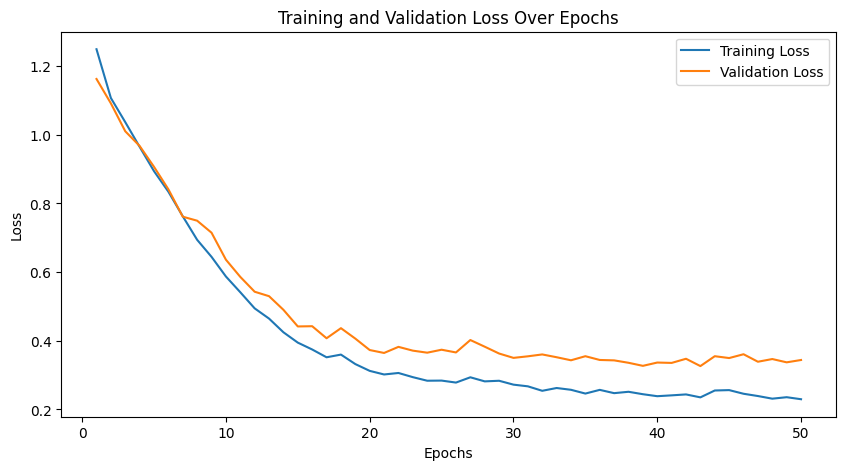

In [ ]:

import os
import time
from glob import glob

import torch # type: ignore
from torch.utils.data import DataLoader # type: ignore
import torch.nn as nn # type: ignore

from data import DriveDataset
from model import build_unet
from loss import DiceLoss, DiceBCELoss
from utils import seeding, create_dir, epoch_time

epochssss = []
train_losses = []
valid_losses = []

def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Load dataset """
    train_x = sorted(glob("../new_data/train/image/*"))
    train_y = sorted(glob("../new_data/train/mask/*"))

    valid_x = sorted(glob("../new_data/test/image/*"))
    valid_y = sorted(glob("../new_data/test/mask/*"))

    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print(data_str)

    """ Hyperparameters """
    H = 512
    W = 512
    size = (H, W)
    batch_size = 2
    num_epochs = 50
    lr = 1e-4
    checkpoint_path = "files/checkpoint.pth"

    """ Dataset and loader """
    train_dataset = DriveDataset(train_x, train_y)
    valid_dataset = DriveDataset(valid_x, valid_y)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()

    """ Training the model """
    best_valid_loss = float("inf")

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        """ Saving the model """
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        epochssss.append(epoch+1)
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        train_losses.append(train_loss)
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        valid_losses.append(valid_loss)
        print(data_str)




import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıplarını çizdirme
plt.figure(figsize=(10, 5))
plt.plot(epochssss, train_losses, label='Training Loss')
plt.plot(epochssss, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()


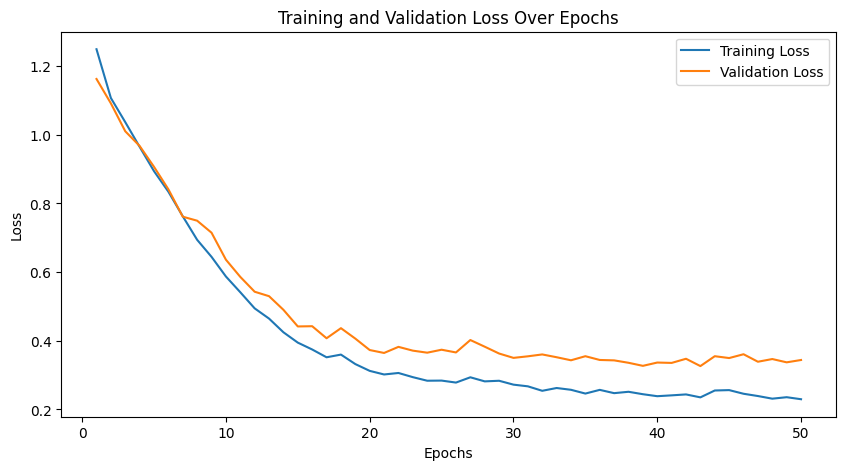

In [37]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıplarını çizdirme
plt.figure(figsize=(10, 5))
plt.plot(epochssss, train_losses, label='Training Loss')
plt.plot(epochssss, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()


In [ ]:
# copy checkpoint to drive

import shutil
import os
new_file_name = input("Enter the new file name: ")
os.chdir('/content/drive/MyDrive/checkpoint files')
os.mkdir(new_file_name)
shutil.copy2('/content/unet_pytorch/UNET/files/checkpoint.pth', f'/content/drive/MyDrive/checkpoint files/{new_file_name}/checkpoint.pth')

Enter the new file name: v100_deneme_v3


'/content/drive/MyDrive/checkpoint files/v100_deneme_v3/checkpoint.pth'

In [ ]:
os.chdir('/content/unet_pytorch/UNET')

In [ ]:
!python3 test.py

 11% 12/112 [00:05<00:42,  2.33it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 18% 20/112 [00:08<00:38,  2.36it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100% 112/112 [00:47<00:00,  2.34it/s]
Jaccard: 0.5889 - F1: 0.7199 - Recall: 0.7865 - Precision: 0.7347 - Acc: 0.9896
FPS:  95.30348904276363


In [ ]:
from IPython.display import Image, display

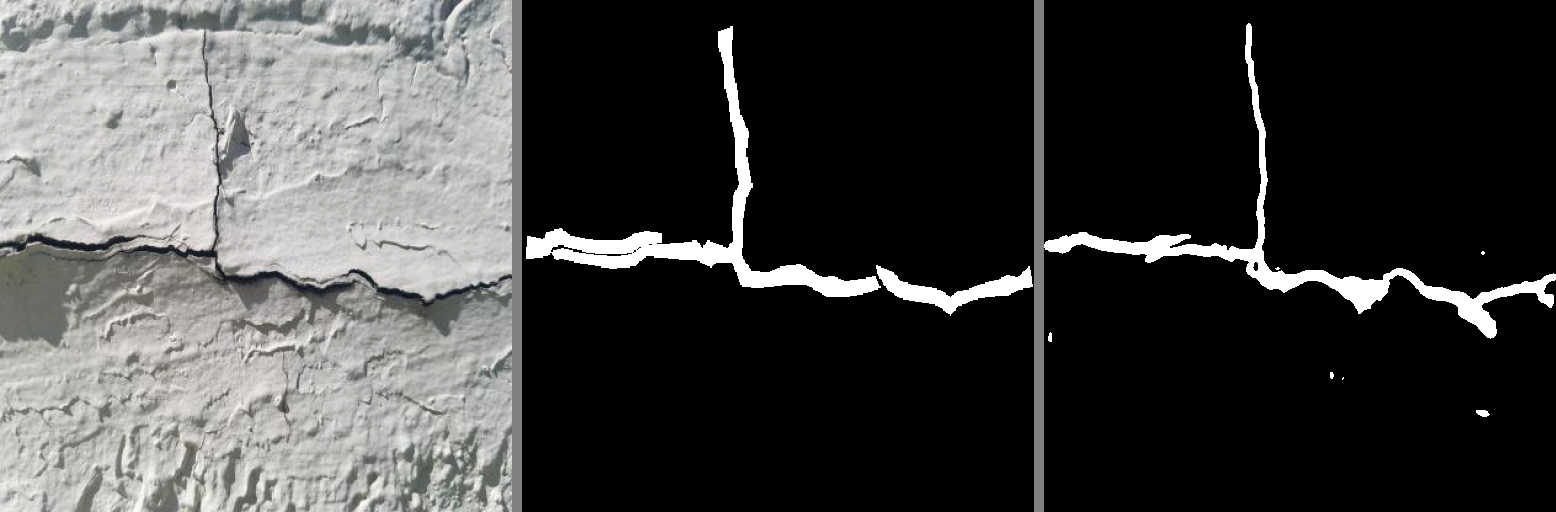

In [ ]:
img = '/content/unet_pytorch/UNET/results/1686.png'
display(Image(filename= img))

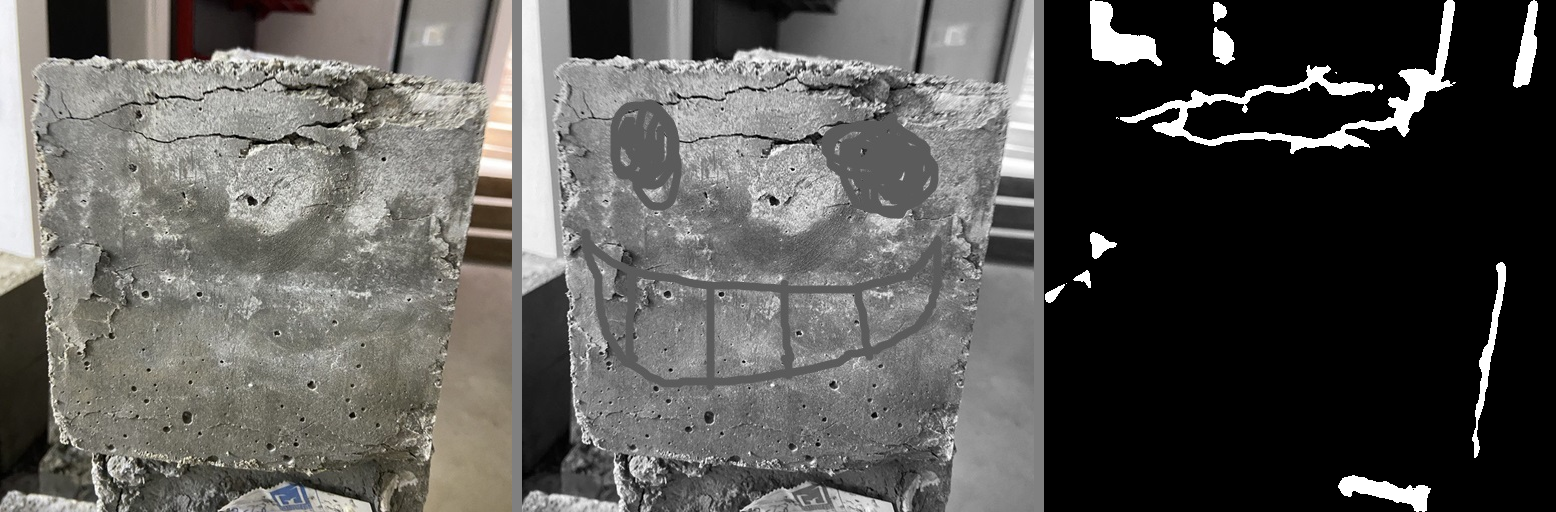

In [29]:
img = '/content/unet_pytorch/UNET/results/sample.png'
display(Image(filename= img))

In [30]:
!pwd

/content/unet_pytorch/UNET


In [ ]:
!pip install opencv-python
!pip install torch torchvision


<IPython.core.display.Javascript object>

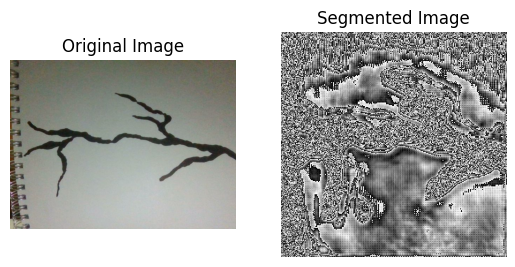

In [35]:
from google.colab import output
from IPython.display import display, Javascript
from base64 import b64decode
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from model import build_unet

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to match the video stream
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for the Capture button to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = output.eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Fotoğrafı çek ve göster
photo_filename = take_photo()
img = cv2.imread(photo_filename)

# Modeli yükleme
model = build_unet()
model.load_state_dict(torch.load('./files/checkpoint.pth', map_location='cpu'))
model.eval()

# Dönüşüm işlemleri
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Görüntüyü işleme
input_tensor = transform(img)
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
    output = model(input_batch)

# Model çıktısını uygun bir formata getirme
output_image = output[0].cpu().numpy()
output_image = output_image.transpose(1, 2, 0)
output_image = (output_image * 255).astype(np.uint8)

# Görüntüleri göster
import matplotlib.pyplot as plt
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
output_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Segmented Image')
plt.imshow(output_rgb)
plt.axis('off')

plt.show()


In [36]:
## MÜKEMMEL BİR SONUÇ ^^^^